# EXPLORE SEDML

In [1]:
import tellurium as te
te.setDefaultPlottingEngine('matplotlib')
import phrasedml

# phrasedml basics

In [2]:
antimony_str = '''
model myModel
  S1 -> S2; k1*S1
  S1 = 10; S2 = 0
  k1 = 1
end
'''

In [3]:
phrasedml_str = '''
  model1 = model "/tmp/myModel" with k1 =5;
  //model2 = model model1 with k1 =6
  //sim1 = simulate uniform(0, 5, 100)
  //task1 = run sim1 on model1
  //plot "Figure 2" time vs S1, S2
'''

In [4]:
#plot "Figure 1" time vs S1, S2

# create the sedml xml string from the phrasedml
sbml_str = te.antimonyToSBML(antimony_str)
phrasedml.setReferencedSBML("/tmp/myModel", sbml_str)

sedml_str = phrasedml.convertString(phrasedml_str)
if sedml_str == None:
    print(phrasedml.getLastError())
print(sedml_str)

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by phraSED-ML version v1.3.0 with libSBML version 5.19.5. -->
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version4" xmlns:sbml="http://www.sbml.org/sbml/level3/version2/core" level="1" version="4">
  <listOfModels>
    <model id="model1" language="urn:sedml:language:sbml.level-3.version-2" source="/tmp/myModel">
      <listOfChanges>
        <changeAttribute target="/sbml:sbml/sbml:model/sbml:listOfParameters/sbml:parameter[@id='k1']/@value" newValue="5"/>
      </listOfChanges>
    </model>
  </listOfModels>
</sedML>



In [5]:
import tempfile, os, shutil

workingDir = tempfile.mkdtemp(suffix="_sedml")

sbml_file = "/tmp/myModel"
#sedml_file = os.path.join(workingDir, 'sed_main.xml')

if True:
    with open(sbml_file, 'wb') as f:
        f.write(sbml_str.encode('utf-8'))
        f.flush()
        print('SBML written to temporary file')

if False:
    with open(sedml_file, 'wb') as f:
        f.write(sedml_str.encode('utf-8'))
        f.flush()
        print('SED-ML written to temporary file')

# For technical reasons, any software which uses libSEDML
# must provide a custom build - Tellurium uses tesedml
if False:
    try:
        import libsedml
    except ImportError:
        import tesedml as libsedml
    sedml_doc = libsedml.readSedML(sedml_file)
    n_errors = sedml_doc.getErrorLog().getNumFailsWithSeverity(libsedml.LIBSEDML_SEV_ERROR)
    print('Read SED-ML file, number of errors: {}'.format(n_errors))
    if n_errors > 0:
        print(sedml_doc.getErrorLog().toString())

# execute SED-ML using Tellurium
#te.executeSEDML(sedml_str, workingDir=workingDir)
te.executeSEDML(sedml_str)

# clean up
#shutil.rmtree(workingDir)

SBML written to temporary file


In [6]:
?te.executeSEDML

Signature:
te.executeSEDML(
    inputStr,
    workingDir=None,
    createOutputs=True,
    saveOutputs=False,
    outputDir=None,
    plottingEngine=None,
)
Docstring:
Run a SED-ML file or combine archive with results.

If a workingDir is provided the files and results are written in the workingDir.

:param inputStr:
:type inputStr:
:return:
:rtype:
File:      ~/home/Technical/repos/SimpleSEDML/ssed/lib/python3.9/site-packages/tellurium/sedml/tesedml.py
Type:      function

# Tasks for SimpleSEDML

1. Run a simulation with changed parameter values
2. Parameter scan
3. Compare the output from two different models
4. Compare simulation results with data

# Repeated tasks in phrasedml

SBML written to temporary file


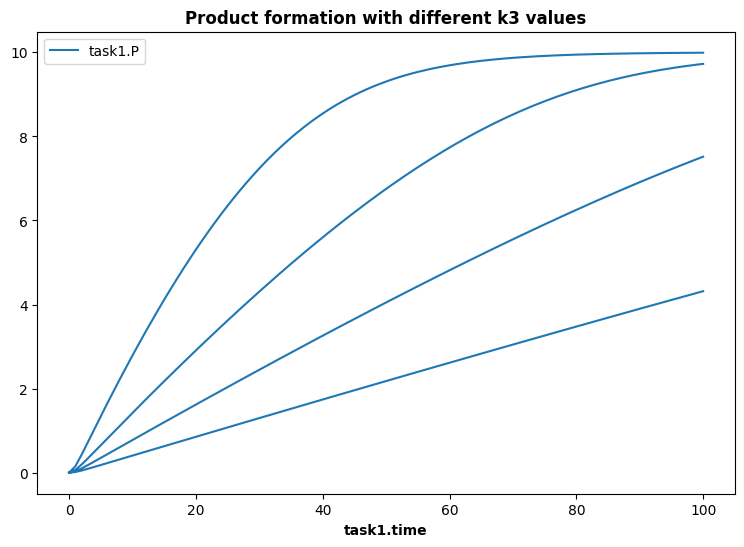

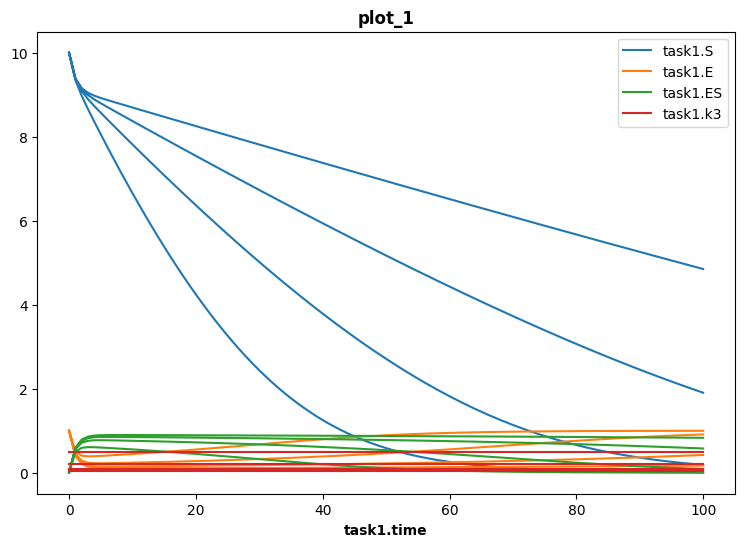

In [7]:
import tellurium as te
import phrasedml

# Define model with Antimony
antimony_str = '''

model anotherModel
   A -> B; 1
   A = 10
   B = 1
end

model enzymeKinetics
    // Compartment
    compartment C = 1.0;
    
    // Species
    species S in C = 10.0;
    species E in C = 1.0;
    species ES in C = 0.0;
    species P in C = 0.0;
    
    // Reactions
    J1: S + E -> ES; k1*S*E;
    J2: ES -> S + E; k2*ES;
    J3: ES -> P + E; k3*ES;
    
    // Parameters
    k1 = 0.1;
    k2 = 0.05;
    k3 = 0.1;
end
'''

# Convert to SBML
sbml_str = te.antimonyToSBML(antimony_str)

# Define PhraSEDML with repeated tasks for parameter sweep
phrasedml_str = '''
    // Reference the model
    model1 = model "enzymeKinetics"
    
    // Define base simulation
    sim1 = simulate uniform(0, 100, 100)
    
    // Define base task
    task0 = run sim1 on model1
    
    // Define repeated task - vary k3 parameter
    task1 = repeat task0 for k3 in [0.05, 0.1, 0.2, 0.5], reset=true
    
    // Plot results
    plot "Product formation with different k3 values" task1.time vs task1.P
    // Add model variable and parameter for reference in the legend
    plot task1.time vs task1.S, task1.E, task1.ES, task1.k3
'''


workingDir = tempfile.mkdtemp(suffix="_sedml")

sbml_file = os.path.join(workingDir, 'enzymeKinetics')
sedml_file = os.path.join(workingDir, 'sed_main.xml')

with open(sbml_file, 'wb') as f:
    f.write(sbml_str.encode('utf-8'))
    f.flush()
    print('SBML written to temporary file')

# Set model reference
phrasedml.setReferencedSBML("enzymeKinetics", sbml_str)

# Convert to SED-ML
sedml_str = phrasedml.convertString(phrasedml_str)

# Execute simulation
if sedml_str:
    te.executeSEDML(sedml_str, workingDir=workingDir)
else:
    print(phrasedml.getLastPhrasedError())

In [8]:
?phrasedml.convertString

Signature: phrasedml.convertString(model)
Docstring:
Convert a model string from phraSEDML to SEDML, or visa versa.  If NULL is returned, an error occurred, which can be retrieved with
@if python
getLastError().
@else
getLastPhrasedError().
@endif

@return The converted model, as a string.

@param model the model as a character string.  May be either SED-ML or phraSED-ML.

@if python
@see getLastError()
@else
@see getLastPhrasedError()
@endif
File:      ~/home/Technical/repos/SimpleSEDML/ssed/lib/python3.9/site-packages/phrasedml/phrasedml.py
Type:      function

In [9]:
!ls -l /var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmp1zug2qoa_sedml

total 8
-rw-r--r--  1 jlheller  staff  3182 Apr 25 12:03 enzymeKinetics


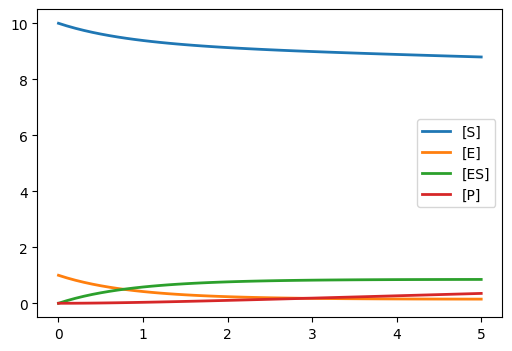

In [10]:
rr = te.loadSBMLModel(sbml_str)
rr.simulate()
rr.plot()

In [11]:
print(phrasedml_str)


    // Reference the model
    model1 = model "enzymeKinetics"
    
    // Define base simulation
    sim1 = simulate uniform(0, 100, 100)
    
    // Define base task
    task0 = run sim1 on model1
    
    // Define repeated task - vary k3 parameter
    task1 = repeat task0 for k3 in [0.05, 0.1, 0.2, 0.5], reset=true
    
    // Plot results
    plot "Product formation with different k3 values" task1.time vs task1.P
    // Add model variable and parameter for reference in the legend
    plot task1.time vs task1.S, task1.E, task1.ES, task1.k3



In [12]:
print(sedml_str)

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by phraSED-ML version v1.3.0 with libSBML version 5.19.5. -->
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version4" xmlns:sbml="http://www.sbml.org/sbml/level3/version2/core" level="1" version="4">
  <listOfModels>
    <model id="model1" language="urn:sedml:language:sbml.level-3.version-2" source="enzymeKinetics"/>
  </listOfModels>
  <listOfSimulations>
    <uniformTimeCourse id="sim1" initialTime="0" outputStartTime="0" outputEndTime="100" numberOfSteps="100">
      <algorithm name="CVODE" kisaoID="KISAO:0000019"/>
    </uniformTimeCourse>
  </listOfSimulations>
  <listOfTasks>
    <task id="task0" modelReference="model1" simulationReference="sim1"/>
    <repeatedTask id="task1" range="vector_for_k3" resetModel="true">
      <listOfRanges>
        <vectorRange id="vector_for_k3">
          <value> 0.05 </value>
          <value> 0.1 </value>
          <value> 0.2 </value>
          <value> 0.5 </value>
        </vectorRange>
     

# Using Phrasedml generated from Claude

In [13]:
!ls /Users/jlheller/home/Technical/repos/SBMLModel/data/*206*

/Users/jlheller/home/Technical/repos/SBMLModel/data/BIOMD0000000206.xml


In [14]:
# Step 1: Reference the model
phrasedml.setWorkingDirectory("/Users/jlheller/home/Technical/repos/SBMLModel/data")
phrasedml_str = """
model1 = model "BIOMD0000000206.xml"
sim1 = simulate uniform(0, 10, 100)  # 0 to 10 seconds with 100 time points
task1 = run sim1 on model1
plot "BioModel 206 Simulation" time vs s1, s5
"""

In [15]:
phrasedml_str = phrasedml.convertString(phrasedml_str)
if len(phrasedml.getLastError()) > 0:
    print(phrasedml.getLastError())

# Source is HTTP

In [16]:
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL3352181362/3/BIOMD0000000206_url.xml"
MODEL = "Wolf2000_Glycolytic_Oscillations"

In [17]:
rr = te.loadSBMLModel(URL)
wolf_sbml_str = rr.getSBML()

In [18]:
phrasedml_str = '''
  model1 = model "/tmp/myModel"
  sim1 = simulate uniform(0, 10, 100); sim1.algorithm=CVODE
  task1 = run sim1 on model1
  plot "Figure 2" time vs S1, S2
'''

In [19]:
print(phrasedml_str)


  model1 = model "/tmp/myModel"
  sim1 = simulate uniform(0, 10, 100); sim1.algorithm=CVODE
  task1 = run sim1 on model1
  plot "Figure 2" time vs S1, S2



In [20]:
# create the sedml xml string from the phrasedml
phrasedml.setReferencedSBML(MODEL, URL)

sedml_str = phrasedml.convertString(phrasedml_str)
if sedml_str == None:
    print(phrasedml.getLastError())
print(sedml_str)

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by phraSED-ML version v1.3.0 with libSBML version 5.19.5. -->
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version4" xmlns:sbml="http://www.sbml.org/sbml/level3/version2/core" level="1" version="4">
  <listOfModels>
    <model id="model1" language="urn:sedml:language:sbml.level-3.version-2" source="/tmp/myModel"/>
  </listOfModels>
  <listOfSimulations>
    <uniformTimeCourse id="sim1" initialTime="0" outputStartTime="0" outputEndTime="10" numberOfSteps="100">
      <algorithm name="CVODE" kisaoID="KISAO:0000019"/>
    </uniformTimeCourse>
  </listOfSimulations>
  <listOfTasks>
    <task id="task1" modelReference="model1" simulationReference="sim1"/>
  </listOfTasks>
  <listOfDataGenerators>
    <dataGenerator id="plot_0_0_0" name="time">
      <math xmlns="http://www.w3.org/1998/Math/MathML">
        <ci> time </ci>
      </math>
      <listOfVariables>
        <variable id="time" symbol="urn:sedml:symbol:time" taskReference="task1"

# Report

## Simple report

In [21]:
antimony_str = '''
model myModel
  S1 -> S2; k1*S1
  S1 = 10; S2 = 0
  k1 = 1
end
'''

In [22]:
# FIXME: Must be written as bytes
sbml_str = te.antimonyToSBML(antimony_str)
with open("/tmp/myModel", 'wb') as f:
        f.write(sbml_str.encode('utf-8'))
        f.flush()
        print('SBML written to temporary file')

SBML written to temporary file


In [34]:
# repeated_task = repeat task1 for k1 in [1, 3, 5], reset=true
phrasedml_str = '''
  model1 = model "/tmp/myModel"
  sim1 = simulate uniform(0, 5, 100)
  task1 = run sim1 on model1
  //report task1.time, task1.S1, task1.S2
  report "Concentration over Time" time, S1, S2
'''

In [35]:
#plot "Figure 1" time vs S1, S2

# create the sedml xml string from the phrasedml
#phrasedml.setReferencedSBML("/tmp/myModel", sbml_str)

sedml_str = phrasedml.convertString(phrasedml_str)
if sedml_str == None:
    print(phrasedml.getLastError())
else:
    print(sedml_str)
    phrasedml.setWorkingDirectory(os.getcwd())
    te.executeSEDML(sedml_str)
    print(te.getLastReport())

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by phraSED-ML version v1.3.0 with libSBML version 5.19.5. -->
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version4" xmlns:sbml="http://www.sbml.org/sbml/level3/version2/core" level="1" version="4">
  <listOfModels>
    <model id="model1" language="urn:sedml:language:sbml.level-3.version-2" source="/tmp/myModel"/>
  </listOfModels>
  <listOfSimulations>
    <uniformTimeCourse id="sim1" initialTime="0" outputStartTime="0" outputEndTime="5" numberOfSteps="100">
      <algorithm name="CVODE" kisaoID="KISAO:0000019"/>
    </uniformTimeCourse>
  </listOfSimulations>
  <listOfTasks>
    <task id="task1" modelReference="model1" simulationReference="sim1"/>
  </listOfTasks>
  <listOfDataGenerators>
    <dataGenerator id="report_0_0_0" name="time">
      <math xmlns="http://www.w3.org/1998/Math/MathML">
        <ci> time </ci>
      </math>
      <listOfVariables>
        <variable id="time" symbol="urn:sedml:symbol:time" taskReference="task1

In [30]:
dir(te)

['DumpJSONInfo',
 'LatexExport',
 'ParameterEstimation',
 'ParameterScan',
 'ParameterScan2D',
 'SBMLDiagram',
 'SensitivityAnalysis',
 'SteadyStateScan',
 'StochasticSimulationModel',
 'UncertaintyAllP',
 'UncertaintySingleP',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__set_model',
 '__spec__',
 '__version__',
 '__warningregistry__',
 'absolute_import',
 'addFileToCombineArchive',
 'addFilesToCombineArchive',
 'analysis',
 'antimonyConverter',
 'antimonyToCellML',
 'antimonyToSBML',
 'cellmlToAntimony',
 'cellmlToSBML',
 'clearTiledFigure',
 'convertAndExecuteCombineArchive',
 'convertCombineArchive',
 'createCombineArchive',
 'disablePlotting',
 'distributed_parameter_scanning',
 'distributed_sensitivity_analysis',
 'distributed_stochastic_simulation',
 'executeCombineArchive',
 'executeInlineOmex',
 'executeInlineOmexFromFile',
 'executeSEDML',
 'exportInlineOmex',
 'extractFileFromCombineArchive',
 'getAppDir

In [31]:
?te.experiment

Object `te.experiment` not found.


## Repeated task

In [26]:
# repeated_task = repeat task1 for k1 in [1, 3, 5], reset=true
phrasedml_str = '''
  model1 = model "/tmp/myModel"
  sim1 = simulate uniform(0, 5, 100)
  task1 = run sim1 on model1
  repeated_task1 = repeat task1 for k1 in [1, 3, 5]
  report repeated_task1.time, repeated_task1.S1, repeated_task1.S2
'''

In [27]:
#plot "Figure 1" time vs S1, S2

# create the sedml xml string from the phrasedml
#phrasedml.setReferencedSBML("/tmp/myModel", sbml_str)

sedml_str = phrasedml.convertString(phrasedml_str)
if sedml_str == None:
    print(phrasedml.getLastError())
else:
    print(sedml_str)
    te.executeSEDML(sedml_str)
    print(te.getLastReport())

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by phraSED-ML version v1.3.0 with libSBML version 5.19.5. -->
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version4" xmlns:sbml="http://www.sbml.org/sbml/level3/version2/core" level="1" version="4">
  <listOfModels>
    <model id="model1" language="urn:sedml:language:sbml.level-3.version-2" source="/tmp/myModel"/>
  </listOfModels>
  <listOfSimulations>
    <uniformTimeCourse id="sim1" initialTime="0" outputStartTime="0" outputEndTime="5" numberOfSteps="100">
      <algorithm name="CVODE" kisaoID="KISAO:0000019"/>
    </uniformTimeCourse>
  </listOfSimulations>
  <listOfTasks>
    <task id="task1" modelReference="model1" simulationReference="sim1"/>
    <repeatedTask id="repeated_task1" range="vector_for_k1" resetModel="false">
      <listOfRanges>
        <vectorRange id="vector_for_k1">
          <value> 1 </value>
          <value> 3 </value>
          <value> 5 </value>
        </vectorRange>
      </listOfRanges>
      <listOfCh

# Notes

1. To execute sedml in Tellurium, need to put the model in an SBML format in a file in a specified working directory.
2. It may be that some part of the sedml workflow fails if the model file has multiple models, that the last model is selected.